# Load dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2

In [2]:
from rasterization_q10.generator_dev import NusLoaderQ10

DATAROOT='/datasets/nuscene/v1.0-mini'

sampling_time = 3
agent_time = 0 # zero for static mask, non-zero for overlap

layer_names = ['drivable_area', 'road_segment', 'road_block',
               'lane', 'ped_crossing', 'walkway', 'stop_line',
               'carpark_area', 'road_divider', 'lane_divider']
colors = [(255, 255, 255), (100, 255, 255), (255, 100, 255),
          (255, 255, 100), (100, 100, 255), (100, 255, 100), (255, 100, 100),
          (100, 100, 100), (50, 100, 50), (200, 50, 50),]

dataset = NusLoaderQ10(
    root=DATAROOT, 
    sampling_time=sampling_time, 
    agent_time=agent_time, 
    layer_names=layer_names, 
    colors=colors,
    resolution=0.1,
    meters_ahead=25,
    meters_behind=25,
    meters_left=25,
    meters_right=25)

print("num_samples: {}".format(len(dataset)))

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.375 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
num_samples: 404


In [3]:
dataset.thres_min = -1
dataset.thres_max = 99999

map_masks, map_img, agent_mask, xy_local, \
virtual_mask, virtual_xy_local, idx = dataset[190] # 100th sample

agent_past = xy_local[0]
agent_future = xy_local[1]
agent_translation = xy_local[2]

virtual_past = virtual_xy_local[0]
virtual_future = virtual_xy_local[1]
virtual_translation = virtual_xy_local[2]

print(map_masks.shape)
print(agent_mask.shape)
print(virtual_mask.shape)

print(len(agent_past))
print(len(virtual_past))

(11, 500, 500, 3)
(500, 500, 3)
(500, 500, 3)
14
5


/home/q10/.pyenv/versions/intelpro/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [4]:
def draw_paths(ax, local_paths):
    past = local_paths[0]
    future = local_paths[1]
    for i in range(len(past)):
        if len(past[i]) != 0:
            ax.plot(past[i][-6:, 0], past[i][-6:, 1], 
                    color='salmon', linewidth=6, alpha=0.5)
        if len(future[i]) != 0:
            ax.plot(future[i][:6, 0], future[i][:6, 1], 
                    color='steelblue', linewidth=6, alpha=0.5)

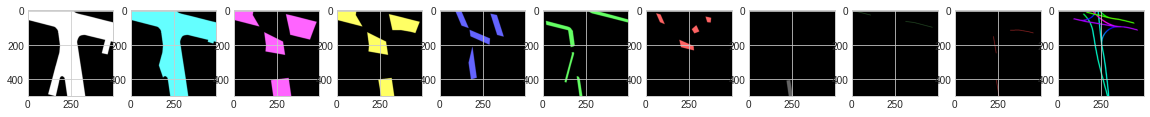

In [5]:
N = map_masks.shape[0]
fig, ax = plt.subplots(1,N, figsize=(20,5))
for i in range(N):
    ax[i].imshow(map_masks[i])
plt.show()

In [6]:
from nuscenes.prediction.input_representation.combinators import Rasterizer
combinator = Rasterizer()

def show_samples():
    agents_combined = combinator.combine(
        np.append(map_masks[[0,5,8,9]], agent_mask[np.newaxis,...], axis=0))
    virtual_agents_combined = combinator.combine(
        np.append(map_masks[[0,5,8,9]], virtual_mask[np.newaxis,...], axis=0))

    fig, ax = plt.subplots(1,2, figsize=(10,5))

    ax[0].set_title("original")
    ax[0].imshow(agents_combined, extent=[-25,25,-25,25])
    if len(xy_local[0]) != 0:
        draw_paths(ax[0], xy_local)
        ax[0].scatter(agent_translation[:,0], agent_translation[:,1], c='r')
    ax[0].set_xlim(-25, 25)
    ax[0].set_ylim(-25, 25)

    ax[1].set_title("generated")
    ax[1].imshow(virtual_agents_combined, extent=[-25,25,-25,25])
    if len(virtual_xy_local[0]) != 0:
        draw_paths(ax[1], virtual_xy_local)
        ax[1].scatter(virtual_translation[:,0], virtual_translation[:,1], c='r')
    ax[1].set_xlim(-25, 25)
    ax[1].set_ylim(-25, 25)

    plt.show()

In [7]:
def load_data(idx, thres_min, thres_max):
    global dataset, map_masks, map_img, agent_mask, xy_local,\
    virtual_mask, virtual_xy_local,\
    agent_past, agent_future, agent_translation,\
    virtual_past, virtual_future, virtual_translation
    
    dataset.thres_min = thres_min
    dataset.thres_max = thres_max
    
    map_masks, map_img, agent_mask, xy_local, \
    virtual_mask, virtual_xy_local, idx = dataset[idx]
    
    agent_past = xy_local[0]
    agent_future = xy_local[1]
    agent_translation = xy_local[2] 
    virtual_past = virtual_xy_local[0]
    virtual_future = virtual_xy_local[1]
    virtual_translation = virtual_xy_local[2]

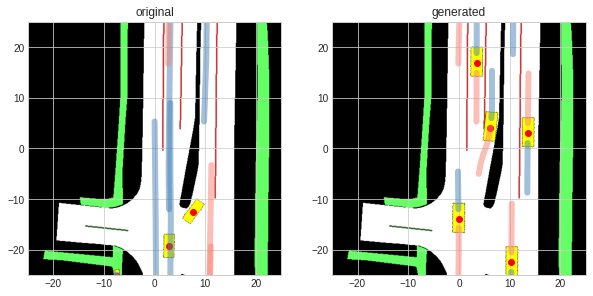

In [8]:
load_data(220, -1, 99999)
show_samples()

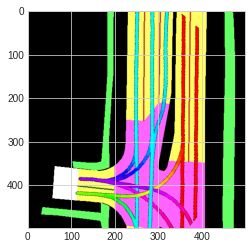

In [9]:
plt.imshow(map_img)

# Save data

scene_images.shape,  
log_prior.shape,  
agent_masks.shape,   
num_src_trajs.shape,  
src_trajs.shape,  
src_lens.shape,  
src_len_idx.shape,   
num_tgt_trajs.shape,  
tgt_trajs.shape,  
tgt_lens.shape,  
tgt_len_idx.shape,   
tgt_two_mask.shape,  
tgt_three_mask.shape,   
decode_start_vel.shape,  
decode_start_pos.shape,  
scene_id.shape   

In [12]:
from torchvision import transforms
import torch.nn.functional as F

p_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([23.0582], [27.3226]),
    transforms.Lambda(lambda x: F.log_softmax(x.reshape(-1), dim=0).reshape(x.shape[1:]))
])

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([23.0582], [27.3226])
])

def generateDistanceMaskFromColorMap(src, scene_size=(64, 64)):
    img = cv2.resize(src, scene_size)
    raw_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(raw_image, 100, 255, cv2.THRESH_BINARY)
    thresh = cv2.bitwise_not(thresh)
    raw_image = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

    raw_map_image = cv2.resize(raw_image.astype(np.float32), dsize=(100, 100), interpolation=cv2.INTER_LINEAR)
    raw_map_image[raw_map_image < 0] = 0 # Uniform on drivable area
    raw_map_image = raw_map_image.max() - raw_map_image # Invert values so that non-drivable area has smaller values

    image = img_transform(raw_image)
    prior = p_transform(raw_map_image)

    return image, prior

In [13]:
def showDistanceMap(image, prior):
    fig, ax = plt.subplots(1,2, figsize=(10,5))

    a = ax[0].imshow(image[0], cmap='gray')
    fig.colorbar(a, ax=ax[0], orientation='vertical')

    b = ax[1].imshow(prior, cmap='gray')
    fig.colorbar(b, ax=ax[1], orientation='vertical')

    plt.show()

In [14]:
def get_agent_mask(agent_past, agent_future, agent_translation):
    map_width = 50
    map_height = 50
    
    num_agents = len(agent_past)
    future_agent_masks = [True] * num_agents

    past_agents_traj = [[[0., 0.]] * 4] * num_agents
    future_agents_traj = [[[0., 0.]] * 6] * num_agents
    
    past_agents_traj = np.array(past_agents_traj)
    future_agents_traj = np.array(future_agents_traj)

    past_agents_traj_len = [4] * num_agents
    future_agents_traj_len = [6] * num_agents

    decode_start_vel = [[0.,0.]] * num_agents
    decode_start_pos = [[0.,0.]] * num_agents

    for idx, path in enumerate(zip(agent_past, agent_future)):
        past = path[0]
        future = path[1]
        pose = agent_translation[idx]

        # agent filtering
        side_length = map_width // 2
        if len(past) == 0 or len(future) == 0 \
        or np.max(pose) > side_length or np.min(pose) < -side_length:
            future_agent_masks[idx] = False

        # agent trajectory
        if len(past) < 4:
            past_agents_traj_len[idx] = len(past)
        for i, point in enumerate(past[:4]):
            past_agents_traj[idx, i] = point

        if len(future) < 6:
            future_agents_traj_len[idx] = len(future)
        for i, point in enumerate(future[:6]):
            future_agents_traj[idx, i] = point

        # vel, pose
        if len(future) != 0:
            decode_start_vel[idx] = (future[0] - agent_translation[idx]) / 0.5
        decode_start_pos[idx] = agent_translation[idx]
        
    return past_agents_traj, past_agents_traj_len, future_agents_traj, future_agents_traj_len, \
        future_agent_masks, decode_start_vel, decode_start_pos

In [15]:
def load_data(idx, thres_min, thres_max):
    global dataset, map_masks, map_img, agent_mask, xy_local,\
    virtual_mask, virtual_xy_local,\
    agent_past, agent_future, agent_translation,\
    virtual_past, virtual_future, virtual_translation
    
    dataset.thres_min = thres_min
    dataset.thres_max = thres_max
    
    map_masks, map_img, agent_mask, xy_local, \
    virtual_mask, virtual_xy_local, idx = dataset[idx]
    
    agent_past = xy_local[0]
    agent_future = xy_local[1]
    agent_translation = xy_local[2] 
    virtual_past = virtual_xy_local[0]
    virtual_future = virtual_xy_local[1]
    virtual_translation = virtual_xy_local[2]

In [16]:
def dataProcessing(virtual=False): 
    global map_masks, agent_past, agent_future, agent_translation, virtual_past, virtual_future, virtual_translation
    
    scene_id = idx

    # map mask & prior mask
    map_image, prior = generateDistanceMaskFromColorMap(map_masks[0], scene_size=(64, 64))

    # agent mask
    past_agents_traj, past_agents_traj_len, future_agents_traj, future_agents_traj_len, \
    future_agent_masks, decode_start_vel, decode_start_pos = get_agent_mask(agent_past, agent_future, agent_translation)

    # virtual agent mask
    past_agents_traj2, past_agents_traj_len2, future_agents_traj2, future_agents_traj_len2, \
    future_agent_masks2, decode_start_vel2, decode_start_pos2 = get_agent_mask(virtual_past, virtual_future, virtual_translation)

    episode = None
    if virtual:
        episode = [past_agents_traj2, past_agents_traj_len2, future_agents_traj2, 
                   future_agents_traj_len2, future_agent_masks2,
                   np.array(decode_start_vel2), np.array(decode_start_pos2), 
                   map_image, prior, scene_id]
    else:
        episode = [past_agents_traj, past_agents_traj_len, future_agents_traj, 
                   future_agents_traj_len, future_agent_masks,
                   np.array(decode_start_vel), np.array(decode_start_pos),
                   map_image, prior, scene_id]

    return episode

In [17]:
def calculateCurve(points):
    if len(points) < 3:
        return 0
    curvature_list = np.empty(0)
    for i in range(len(points) - 2):
        A = points[i]
        B = points[i + 1]
        C = points[i + 2]
        curvature_value = abs(curvature(A, B, C))
        curvature_list = np.append(curvature_list, curvature_value)
    return np.average(curvature_list)

In [25]:
def dataGeneration(thres=0.02, curved_ratio=0.3):
    episodes = []
    
    num_linear = 0
    num_curved = 0
    
    N = len(dataset)
    
    # count the number of curved agents
    global agent_past
    for idx in range(N):
        load_data(idx, -1, thres)
        num_linear += len(agent_past)
        load_data(idx, thres, 99999)
        num_curved += len(agent_past)
    
    # original data
    for idx in range(N):
        load_data(idx, -1, 99999)
        episode = dataProcessing()
        if sum(episode[4]) > 0:
            episodes.append(episode)
    
    # generate curved data
    curved_target = (num_linear/(1-curved_ratio)) * curved_ratio - num_curved
    index = 0
    while curved_target > 0:
        load_data(index, thres, 99999)
        episode = dataProcessing(virtual=True)
        
        n = sum(episode[4])
        
        if n > 0:
            episodes.append(episode)
            curved_target -= n
            
        index += 1
        if index > N - 1:
            index = 0
    
    return episodes

In [255]:
thres = 0.02
curved_ratio = 0.3

# parsed_data = dataGeneration(thres=thres, curved_ratio=curved_ratio)

# print("Number of Data: {}".format(len(parsed_data)))

/home/q10/ws/repos/naverlabs2020/nuscene_parser/rasterization_q10/input_representation/agents.py:32: RuntimeWarning: invalid value encountered in double_scalars
  curvature = 4 * area / (np.linalg.norm(A - B) * np.linalg.norm(B - C) * np.linalg.norm(C - A))
/home/q10/.pyenv/versions/intelpro/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/q10/ws/repos/naverlabs2020/nuscene_parser/rasterization_q10/input_representation/agents.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  curvature = 4 * area / (np.linalg.norm(A - B) * np.linalg.norm(B - C) * np.linalg.norm(C - A))


KeyboardInterrupt: 

In [ ]:
import pickle

filename = 'nuscene_'+str(thres)+'_'+str(curved_ratio)
with open(filename+'.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [23]:
load_data(160, -1, 99999999)
episode = dataProcessing()
episode

[array([[[  -7.07449409,  -59.74677848],
         [  -7.04884525,  -59.78083927],
         [  -7.02415532,  -59.81386058],
         [  -6.99662894,  -59.85099949]],
 
        [[  -9.56119812, -104.05357191],
         [  -9.46515519, -104.05444125],
         [  -9.47814464, -104.0539176 ],
         [  -9.49317275, -104.05431259]],
 
        [[  -5.99240456,  -24.83603253],
         [  -5.94296097,  -24.82601599],
         [  -5.89447628,  -24.81495999],
         [  -5.89447628,  -24.81495999]],
 
        [[  14.24376378,  -18.98339929],
         [  14.35359395,  -18.98982849],
         [  14.46242493,  -18.99621741],
         [  14.4717062 ,  -18.84046485]],
 
        [[  -0.81365586,  -40.4132756 ],
         [  -0.86213224,  -44.61973683],
         [  -0.92046643,  -48.52455617],
         [  -0.98431661,  -52.81446587]],
 
        [[ -19.44976363,   -9.35540389],
         [ -19.4139696 ,   -9.41089072],
         [ -19.37817557,   -9.46637754],
         [ -19.56310719,   -9.33682332]],


In [ ]:
episode = [past_agents_traj, past_agents_traj_len, future_agents_traj, 
                   future_agents_traj_len, future_agent_masks, decode_start_vel, 
                   decode_start_pos, map_image, prior, scene_id]

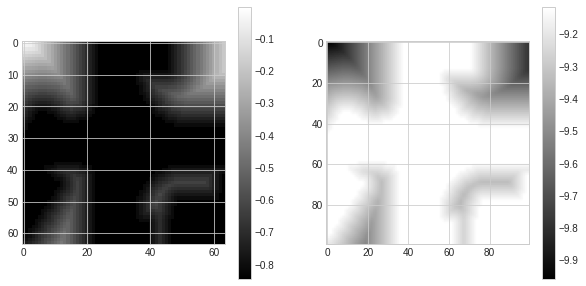

In [24]:
showDistanceMap(episode[7], episode[8])

In [21]:
np.array(episode[6])

array([[  -7.05521974,  -59.7155295 ],
       [  -9.66027889, -104.05358093],
       [  -5.99240456,  -24.83603253],
       [  14.24376378,  -18.98339929],
       [  -0.73009606,  -36.10614584],
       [ -19.48455847,   -9.29995735],
       [  40.87793705,  -11.72033421],
       [  35.16106345,   26.13366392],
       [  13.69836856,  -21.51448484],
       [   3.9772952 ,  -37.65601828],
       [  24.58221692,  -11.43470777],
       [  14.80599253,  -15.66235069],
       [ -24.31875193,  -17.54892981],
       [  13.73779127,  -26.8423968 ],
       [ -11.65592512,    7.88665208],
       [  -9.04273466,  -77.96027903],
       [  13.6796833 ,  -24.13786126],
       [  -3.04272008,    8.43815817],
       [   4.30849035,  -28.12462343],
       [   8.7294874 ,   42.66474894],
       [ -27.40022452,  -22.46379631],
       [ -21.04554757,  -11.8501501 ],
       [  27.32785566,  -11.32521374],
       [ -11.81719349,  -30.87030622],
       [  35.11019931,   28.86893261],
       [ -22.57508029,  -

In [28]:
img = map_masks[0].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
raw_image = cv2.bitwise_not(gray)
raw_image = cv2.resize(raw_image.astype(np.float32), dsize=(100,100), interpolation=cv2.INTER_LINEAR)
ret, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

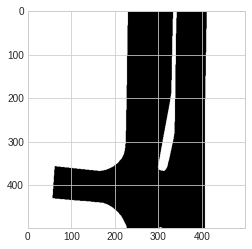

In [29]:
plt.imshow(thresh)

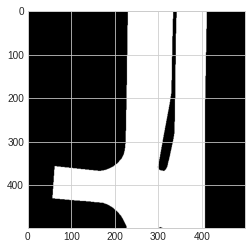

In [25]:
plt.imshow(img)

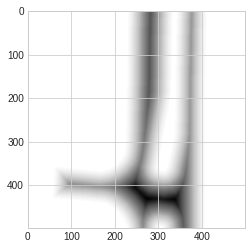

In [20]:
img = map_masks[0].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
result = cv2.normalize(dist_transform, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)

plt.imshow(result)

In [266]:
raw_image

array([[  0.,   0.,   0., ..., 255., 255., 255.],
       [  0.,   0.,   0., ..., 255., 255., 255.],
       [  0.,   0.,   0., ..., 255., 255., 255.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]], dtype=float32)

In [ ]:
import pickle

thres = 0.02
curved_ratio = 0.3

filename = 'nuscene_'+str(thres)+'_'+str(curved_ratio)
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

In [ ]:
import pickle

data = {
    'a': [1, 2.0, 3, 4+6j],
    'b': ("character string", b"byte string"),
    'c': {None, True, False}
}

# save
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

# load
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

In [ ]:
import pickle
import gzip

data = {
    'a': [1, 2.0, 3, 4+6j],
    'b': ("character string", b"byte string"),
    'c': {None, True, False}
}

# save and compress.
with gzip.open('testPickleFile.pickle', 'wb') as f:
    pickle.dump(data, f)

# load and uncompress.
with gzip.open('testPickleFile.pickle','rb') as f:
    data = pickle.load(f)

In [203]:
map_masks[0].shape

(500, 500, 3)

In [ ]:
    global dataset, map_masks, map_img, agent_mask, xy_local,\
    virtual_mask, virtual_xy_local,\
    agent_past, agent_future, agent_translation,\
    virtual_past, virtual_future, virtual_translation
    
    dataset.thres_min = thres_min
    dataset.thres_max = thres_max
    
    map_masks, map_img, agent_mask, xy_local, \
    virtual_mask, virtual_xy_local, idx = dataset[idx]
    
    agent_past = xy_local[0]
    agent_future = xy_local[1]
    agent_translation = xy_local[2] 
    virtual_past = virtual_xy_local[0]
    virtual_future = virtual_xy_local[1]
    virtual_translation = virtual_xy_local[2]

In [209]:
np.flip(agent_past[0], axis=0), agent_translation[0], agent_future[0]

(array([[ -7.29759586, -26.71001462],
        [ -7.41976551, -25.88019863],
        [ -7.44627145, -25.51271743],
        [ -7.45954975, -25.40740035],
        [ -7.47347224, -25.30284814],
        [ -7.48675055, -25.19753107]]),
 array([ -7.50002886, -25.09221399]),
 array([[ -7.51395135, -24.98766178],
        [ -7.52722965, -24.88234471],
        [ -7.52722965, -24.88234471]]))

In [81]:
np.array(prior).shape, cv2.cvtColor(map_masks[0].copy(), cv2.COLOR_BGR2GRAY).shape

((100, 100), (500, 500))

In [97]:
a = img_transform(cv2.cvtColor(map_masks[0].copy(), cv2.COLOR_BGR2GRAY))

In [104]:
np.min(np.array(a[0]))

-0.8439241

In [92]:
np.min(dist_transform)

0.0

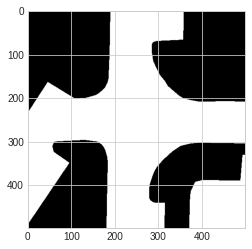

In [105]:
plt.imshow(a[0], cmap='gray')

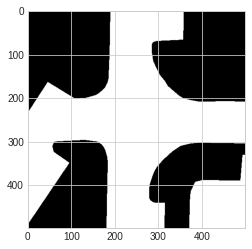

In [82]:
plt.imshow(raw_image, cmap='gray')

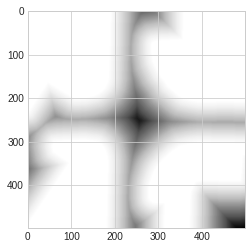

In [107]:
plt.imshow(dist_transform, cmap='gray')

In [ ]:
past_agents_traj, past_agents_traj_len, future_agents_traj, future_agents_traj_len, future_agent_masks, decode_start_vel, decode_start_pos, map_image, prior, scene_id=\


In [ ]:

import cv2 as cv
import numpy as np



img = cv.imread('rectangle.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)


# 이진화된 결과를 dist_transform 함수의 입력으로 사용합니다. 

dist_transform = cv.distanceTransform(thresh, cv.DIST_L2, 5)
# dist_transform  함수를 사용하면 실수 타입(float32)의 이미지가 생성됩니다. 화면에 보여주려면 normalize 함수를 사용해야 합니다. 
result = cv.normalize(dist_transform, None, 255, 0, cv.NORM_MINMAX, cv.CV_8UC1)

cv.imshow("dist_transform", result)
cv.imshow("src", img)

cv.waitKey(0)

In [30]:
dist_transform = cv2.distanceTransform(cv2.cvtColor(map_masks[0].copy(), cv2.COLOR_BGR2GRAY), cv2.DIST_L2, 5)
result = cv2.normalize(dist_transform, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)

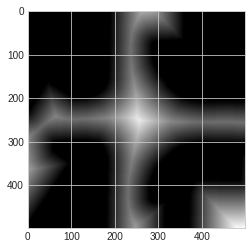

In [31]:
plt.imshow(result, cmap='gray')

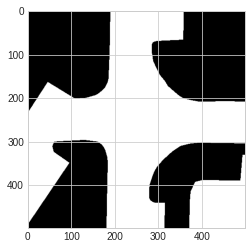

In [32]:
plt.imshow(map_masks[0], cmap='gray')

In [1]:
import pickle

In [19]:
# filename = 'nuscene_0.02_0.3.pickle'
filename = 'nuscene_0.02_0.5.pickle'

with open(filename, 'rb') as f:
    dataset = pickle.load(f)

In [20]:
import random

ratio = 0.7

num_data = len(dataset)
print(num_data)

shuffled = dataset.copy()
random.shuffle(shuffled)

split = int(num_data*ratio)

train = shuffled[:split]
val = shuffled[split:]

with open(filename+'_train', 'wb') as f:
    pickle.dump(train, f, pickle.HIGHEST_PROTOCOL)
    
with open(filename+'_val', 'wb') as f:
    pickle.dump(val, f, pickle.HIGHEST_PROTOCOL)

1208


In [8]:
test = dataset.copy()

In [10]:
import random
random.shuffle(test)
len(test)

382

In [11]:
dataset[0][0], test[0][0]

(array([[[ 37.5393649 ,  60.7086569 ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]],
 
        [[ 18.7372296 ,  57.21347847],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]],
 
        [[  9.02274627, -23.15039525],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]],
 
        [[  6.0548903 ,  31.43744319],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]],
 
        [[ -4.50909976,  11.74452532],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]],
 
        [[ -8.04777507,  74.19388417],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ],
         [  0.        ,   0.        ]],
 
        [[  7.75752939, -57.40158484],
       

In [13]:
a = [[1,2,3,4,5], [2,3,4,5,6], [3,4,5,6,7]]
b = [[11,12,13,14,15], [12,13,14,15,16], [13,14,15,16,17]]
c = [[21,22,23,24,25], [22,23,24,25,26], [23,24,25,26,27]]

arr = []
arr.append(a)
arr.append(b)
arr.append(c)
arr

([[[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]],
  [[11, 12, 13, 14, 15], [12, 13, 14, 15, 16], [13, 14, 15, 16, 17]],
  [[21, 22, 23, 24, 25], [22, 23, 24, 25, 26], [23, 24, 25, 26, 27]]],
 3)

In [14]:
arr2 = arr.copy()

random.shuffle(arr2)
arr2

[[[11, 12, 13, 14, 15], [12, 13, 14, 15, 16], [13, 14, 15, 16, 17]],
 [[1, 2, 3, 4, 5], [2, 3, 4, 5, 6], [3, 4, 5, 6, 7]],
 [[21, 22, 23, 24, 25], [22, 23, 24, 25, 26], [23, 24, 25, 26, 27]]]

In [22]:
past_agents_traj,\
        past_agents_traj_len,\
        future_agents_traj,\
        future_agents_traj_len,\
        future_agent_masks,\
        decode_start_vel,\
        decode_start_pos,\
        map_image,\
        prior,\
        scene_id = dataset[5]

In [24]:
len(future_agent_masks), future_agent_masks

(18,
 [False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False])

In [38]:
import numpy as np

a = [1,2,3,4,5]

q = [True, True, False, False, True]
qq = [True, False, False, False, True]

b = np.arange(5)[q and qq]
b

array([0, 4])

In [31]:
q and qq

[True, False, False, False, True]

In [33]:
q[qq]

TypeError: list indices must be integers or slices, not list

In [51]:
import torch

mask = torch.tensor([True, True, False, False, True])
mask2 = torch.tensor([True, False, False, False, True])

torch.arange(len(mask))[mask * mask2]

tensor([0, 4])

In [50]:
mask * mask2

tensor([ True, False, False, False,  True])

In [67]:
for sample in val:
    past_agents_traj,\
        past_agents_traj_len,\
        future_agents_traj,\
        future_agents_traj_len,\
        future_agent_masks,\
        decode_start_vel,\
        decode_start_pos,\
        map_image,\
        prior,\
        scene_id = sample
    if len(past_agents_traj) <= 0 or len(future_agents_traj) <= 0:
        print('a')


In [72]:
past_agents_traj_len

[4, 4, 4, 4, 4, 4]

In [68]:
decode_start_pos

array([[-47.48919622,   6.43303026],
       [  0.32035706,  75.77641945],
       [  4.77317456,  82.09827423],
       [ -8.37152961, -13.8938972 ],
       [ -1.95467864, -13.49207332],
       [ -0.78683828, -20.00554593]])

In [69]:
decode_start_vel

array([[-5.08496948e-02,  3.67663426e+00],
       [-2.47298463e-01,  3.74874944e+00],
       [ 4.54950129e-01,  3.72238169e+00],
       [-3.31517074e+00, -1.75826128e+00],
       [ 2.98427949e-13, -3.44613227e-13],
       [-2.41091083e+00,  2.83193208e+00]])